# Advanced Lane Lines Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Camera Calibration
First, chessboard images are read, and corners got detected. 

In [1]:
# Needed imports for the Camera Calibration
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

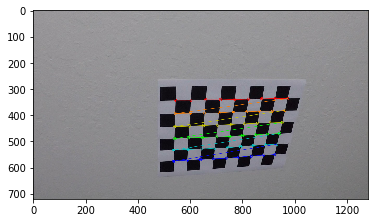

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Used to print only an image from the chessboard images.
toPrint = True

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Print a sample of a correctly detected chessboard image
        if toPrint:
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            toPrint = False


Now to calculate the camera matrix, and the distortion coefficients. 

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Following is a test on undistoring an image.

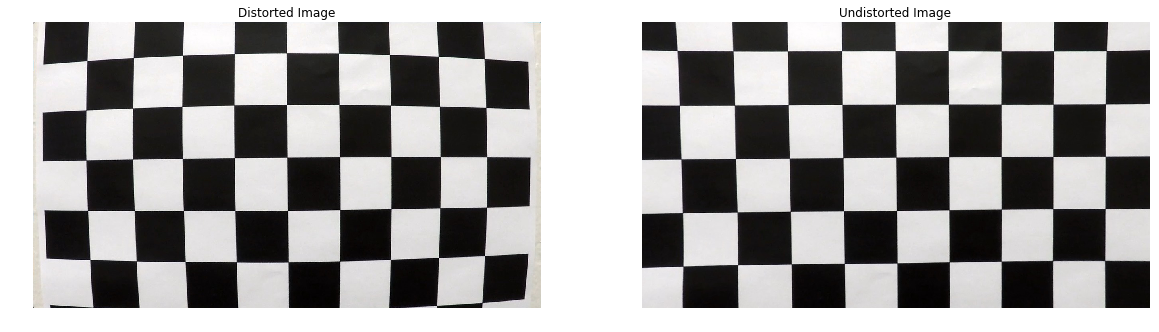

In [4]:

def undistort (img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
img = cv2.imread('camera_cal/calibration1.jpg', 1)

dst = undistort(img)


_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

The same code will be applyed to all images entering the advanced lane lines finding pipeline.

## Binary Image
Images got converted to binary by combining S threshold binary, sobel x threshold binary and sobel y threshold binary. The min and max thresholds obtained experimantaly.

In [5]:
def convertToBinary(img, s_thresh=(150, 255), sx_thresh=(100, 255), sy_thresh=(100,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sy_thresh[0]) & (scaled_sobely <= sy_thresh[1])] = 1
    
    
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined = np.zeros_like(s_channel)
    combined[(s_binary == 1) | (sxbinary == 1) | (sybinary == 1)] = 255
    
    return combined

Following are some tests on images

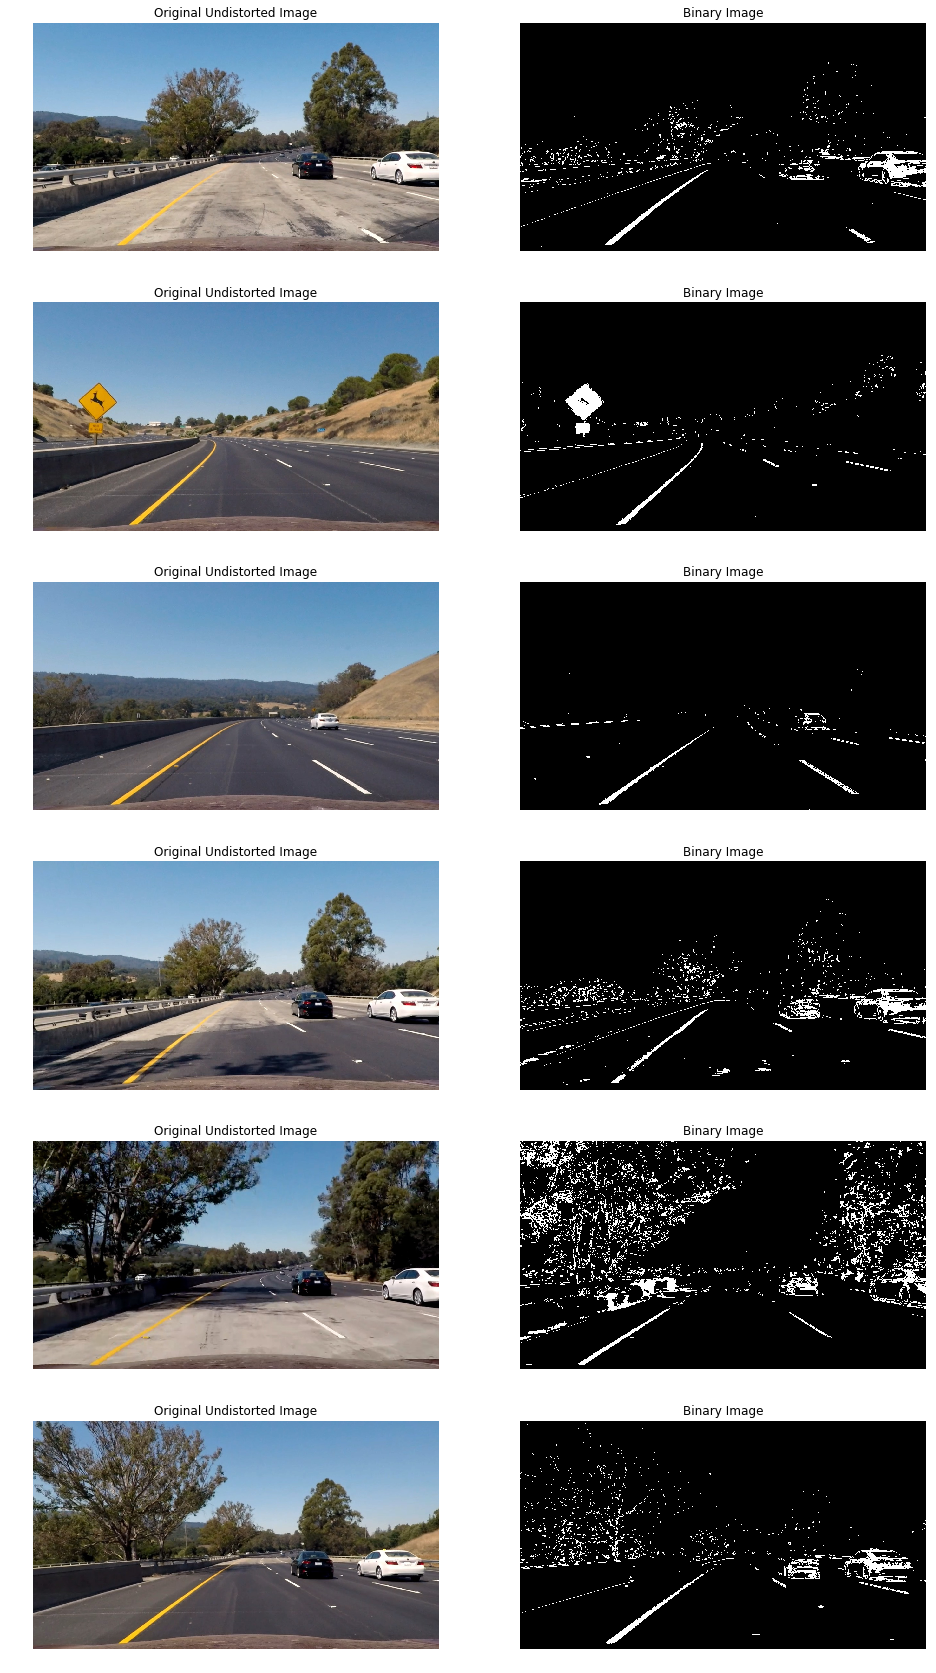

In [6]:
images = glob.glob('test_images/test*.jpg')

_, ax = plt.subplots(len(images), 2, figsize=(16,len(images) * 5))

for i,fname in enumerate(images):
    
    tst = cv2.imread(fname, 1)
    tst = undistort(tst)
    dst = convertToBinary(tst)
        
    ax[i][0].imshow(cv2.cvtColor(tst,cv2.COLOR_BGR2RGB))
    ax[i][0].axis("off")
    ax[i][0].set_title("Original Undistorted Image")
    
    ax[i][1].imshow(dst, cmap='gray')
    ax[i][1].axis("off")
    ax[i][1].set_title("Binary Image")

plt.show()

## Percpective transformation
To convert image into Birds-Eye view, we need to apply a percpective transformation. Four points will be taken and predefined in the images to be used for the transformation.

The trick here is how to pick these four points, I tried with the straight lines image until I get the best points. I picked the points manually from the image, and tested if after tranforming, these lines will be a straight lines.

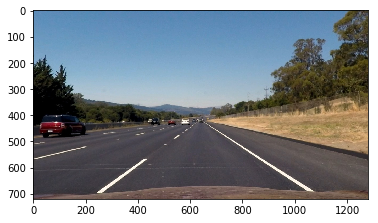

In [7]:
straight_image = cv2.imread('test_images/straight_lines2.jpg', 1)
s_ud_img = undistort(straight_image)
plt.imshow(cv2.cvtColor(s_ud_img, cv2.COLOR_BGR2RGB))

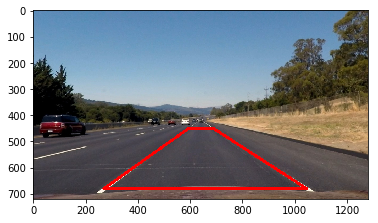

In [8]:
# source points
spt = np.array([[ 270, 680],[ 595, 450],[688, 450],[1045, 680]])
test = s_ud_img.copy()
cv2.polylines(test,[spt],True,(0,0,255), 10)
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))

The previous points forms the source of percpective transformation. The destination points represents where we want the source points to be in the percpective. 

We are happy with the y-axis, so no offsetting will be applied. However, it would be better to include a wider percpective, so an offset of 250 px is used in the x-axis.

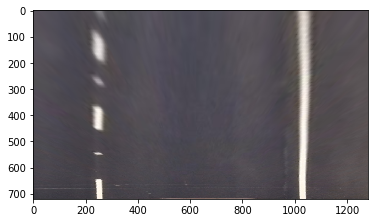

In [9]:
# destination points
offset = 250

dpt = np.array([[ offset, 720],[ offset, 0],[1280 - offset, 0],[1280 - offset, 720]], dtype='float32')
M = cv2.getPerspectiveTransform(spt.astype('float32'), dpt)
Minv = cv2.getPerspectiveTransform(dpt, spt.astype('float32'))
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(s_ud_img, M, gray.shape[::-1])
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

In [10]:
def warp(img):
    return cv2.warpPerspective(img, M, img.shape[1::-1])

def unwarp(img):
    return cv2.warpPerspective(img, Minv, img.shape[1::-1])

Putting it all together, the image got undistorted, then converted to binary, then warped. Following are the result of the previous process.

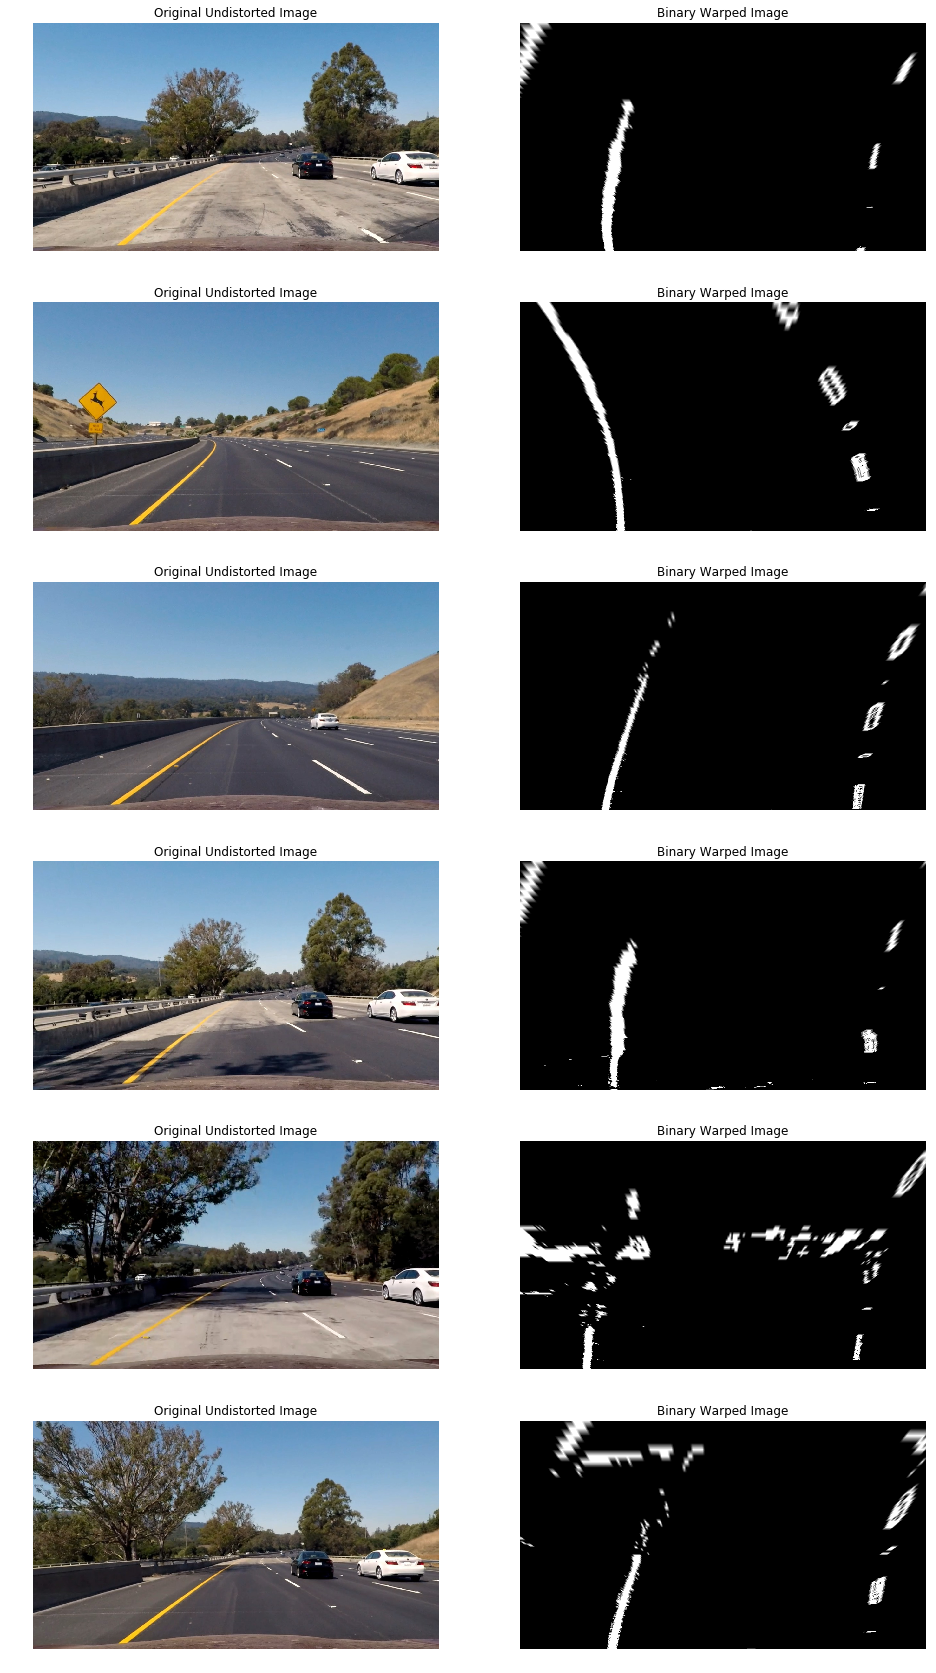

In [11]:
images = glob.glob('test_images/test*.jpg')

_, ax = plt.subplots(len(images), 2, figsize=(16,len(images) * 5))

for i,fname in enumerate(images):
    
    tst = cv2.imread(fname, 1)
    tst = undistort(tst)
    dst = convertToBinary(tst)
    dst = warp(dst)
        
    ax[i][0].imshow(cv2.cvtColor(tst,cv2.COLOR_BGR2RGB))
    ax[i][0].axis("off")
    ax[i][0].set_title("Original Undistorted Image")
    
    ax[i][1].imshow(dst, cmap='gray')
    ax[i][1].axis("off")
    ax[i][1].set_title("Binary Warped Image")

plt.show()

To summarize, the preprocessing pipeline is as following.

In [12]:
# image processing pipeline:
def imageProcessingPipeline(img):
    tst = undistort(img)
    dst = convertToBinary(tst)
    dst = warp(dst)
    return dst, tst

## Lines finding


In order to identify where the lane might be, a histogram of the points is calculated for the bottom half of the image.

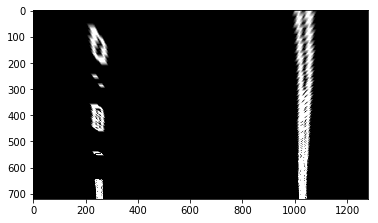

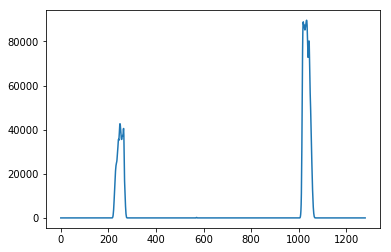

In [13]:
#s_ud_img
binary, ud_img = imageProcessingPipeline(straight_image)
histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plt.imshow(binary, cmap='gray')
plt.figure()
plt.plot(histogram)

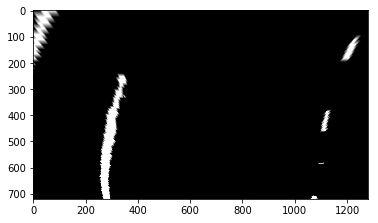

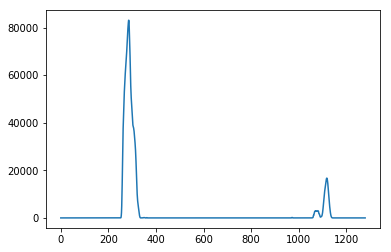

In [14]:
test1image = cv2.imread('test_images/test1.jpg', 1)
binary, ud_img = imageProcessingPipeline(test1image)
histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
plt.imshow(binary, cmap='gray')
plt.figure()
plt.plot(histogram)

This histogram is used to identify where the lines are starting from. 

Following, a windowed search is used to identify the points of each lane line.

Starting from the location identified by the historgram, and for each window, the average of points location is calculated, and it is used as the location for the next window. As the window size is fixed, part of the points are identified as lane points, those which only are inside the identified windows. those points will be used to fit a polynomial that represents the best fit for the lane line. This is done for each lane line, i.e. the right and the left.

In [15]:

def calculatepoints(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    return leftx, lefty, rightx, righty

After collecting the points that relies in each line, the polyfit is used to determine the best fit curve for each line.

(720, 0)

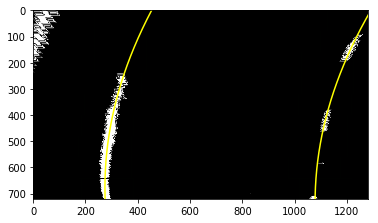

In [16]:
binary_warped = binary
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
leftx, lefty, rightx, righty = calculatepoints(binary)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Using best fit curves, we can compute the curveture for each line. 

In [40]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = np.max(ploty)
def calculateCurveture(left_fit, right_fit):
    
    # Fit new polynomials to x,y in world space
    left_fix_x = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fix_x = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fix_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fix_x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
left_curverad, right_curverad = calculateCurveture(left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm')

421.943694356951 m 416.0257141627799 m


Calculate the location to the center of the lane


In [21]:
def CalculateDistanceFromCenter(left_fit, right_fit):
    rightpt = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    leftpt = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    centerpt = np.mean([rightpt, leftpt])
    deviationFromCenter = 1280/2 - centerpt
    return xm_per_pix * deviationFromCenter
distanceFromCenter = CalculateDistanceFromCenter(left_fit, right_fit)
print (distanceFromCenter, 'm')

-0.19475829378113363 m


The Identified lane is plotted against the undistorted image

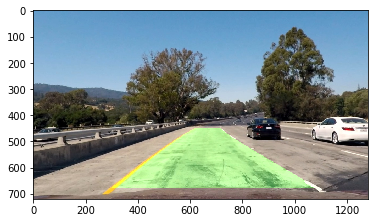

In [30]:
def plotLane(binary_warped, undisimage, left_fit, right_fit):
# Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undisimage.shape[1], undisimage.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undisimage, 1, newwarp, 0.3, 0)
    return result

result = plotLane(binary_warped, ud_img, left_fit, right_fit)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

Adding Curveture and distance from the center values to each image.

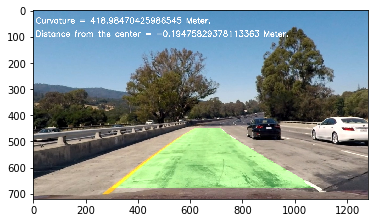

In [31]:
# Add Curv and distance,
def addCurvAndDist(img, curv, dist):
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvM = "Curvature = " + str(curv) + " Meter."
    distM = "Distance from the center = " + str(dist) +  " Meter."
    cv2.putText(img,curvM,(10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,distM,(10,100), font, 1,(255,255,255),2,cv2.LINE_AA)
addCurvAndDist(result, np.mean([left_curverad, right_curverad]), distanceFromCenter)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
    

In [34]:
# putting altogether
def pipeline(img):
    binary, ud_img = imageProcessingPipeline(img)
    leftx, lefty, rightx, righty = calculatepoints(binary)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_curverad, right_curverad = calculateCurveture(left_fit, right_fit)
    curveture = np.mean([left_curverad, right_curverad])
    distanceFromCenter = CalculateDistanceFromCenter(left_fit, right_fit)
    result = plotLane(binary, ud_img, left_fit, right_fit)
    addCurvAndDist(result, curveture, distanceFromCenter)
    return result

Testing the whole pipeline on the test images.

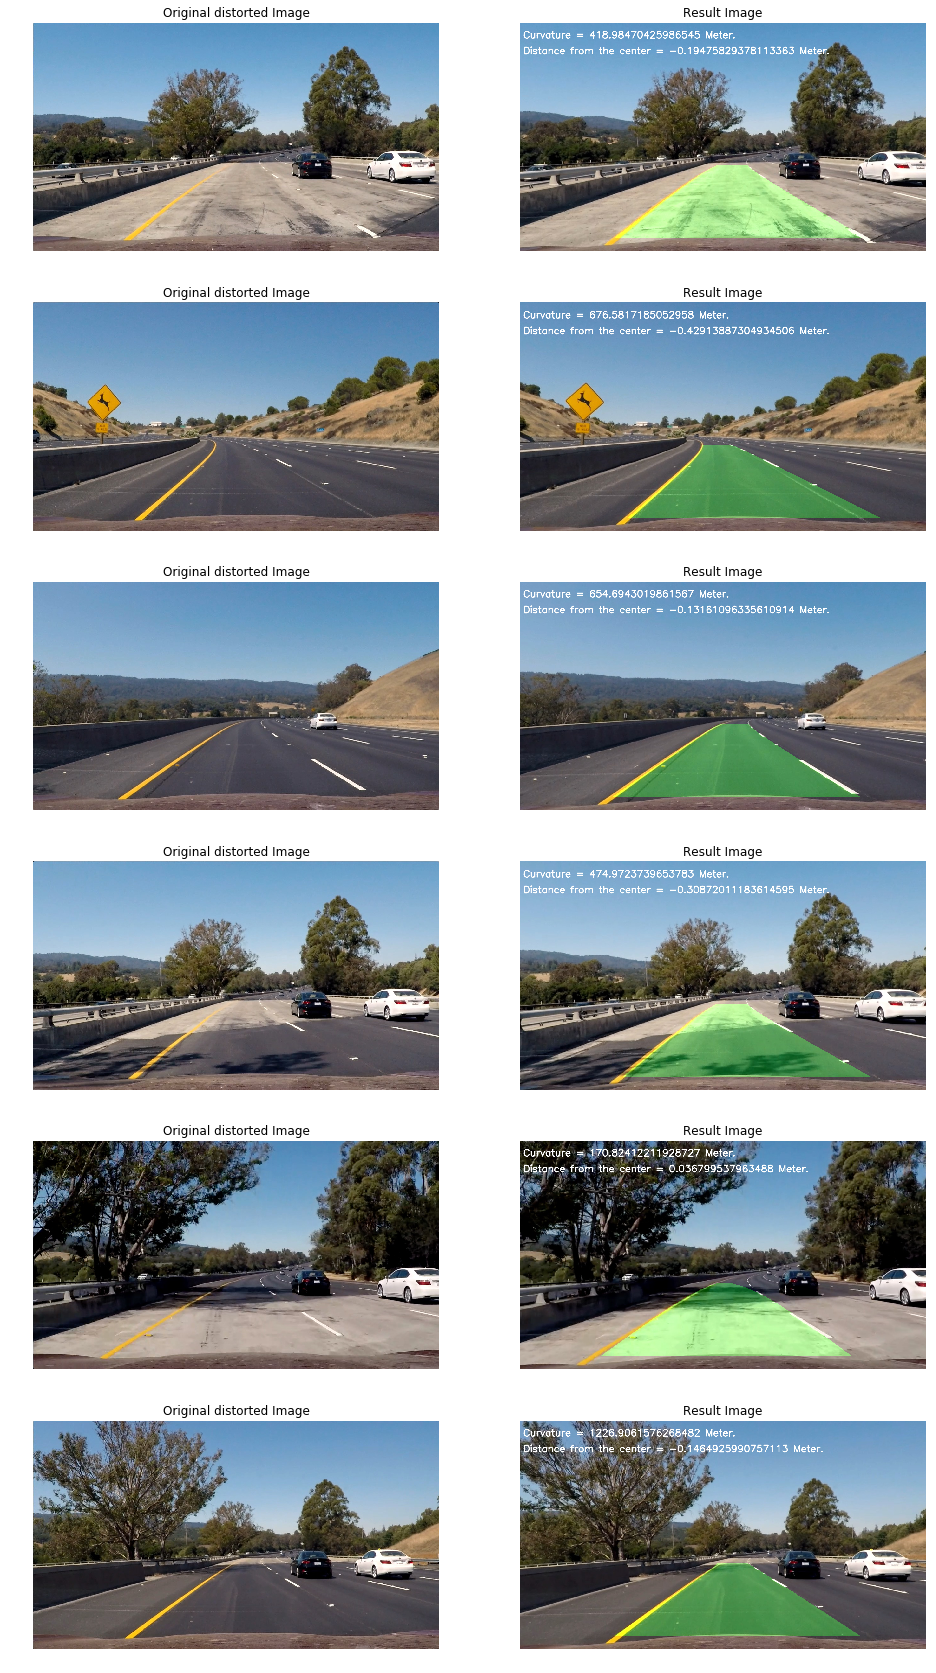

In [35]:
images = glob.glob('test_images/test*.jpg')

_, ax = plt.subplots(len(images), 2, figsize=(16,len(images) * 5))

for i,fname in enumerate(images):
    
    tst = cv2.imread(fname, 1)
    dst = pipeline(tst)

        
    ax[i][0].imshow(cv2.cvtColor(tst,cv2.COLOR_BGR2RGB))
    ax[i][0].axis("off")
    ax[i][0].set_title("Original distorted Image")
    
    ax[i][1].imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
    ax[i][1].axis("off")
    ax[i][1].set_title("Result Image")

plt.show()

Testing the whole pipeline on the project video

In [37]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [38]:
# Create a video
white_output = 'output1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:06<00:00,  5.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

Wall time: 4min 7s


In [39]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))